# Notebook 1 of 6 - Data Access and Exploration 
**Author:** Alexandru Mihalache 

**Date:** November 2022


In [2]:
import pandas as pd
import numpy as np

#Plotting libs
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


#Football libs
import socceraction
from socceraction.data.statsbomb import StatsBombLoader
from mplsoccer import Pitch, Sbopen, VerticalPitch
import socceraction.spadl as spadl
import matplotsoccer as mps
import socceraction.xthreat as xthreat
import socceraction.spadl as spadl
from socceraction.vaep import VAEP

# utils
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

/Users/alexmihalache/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Introduction


**Project Aims:**

- For this project I will be looking at football transfers, predicting the contribution a player may make in a new team. 
- I will model how a team plays, then using the model to make predictions on player output. 
- The motivation for this project has been to research new methods on assessing potential transfer targets. Initially the aim has been to find new teams for players, who used to be regular starters, but have fallen down the pecking order at their teams. And with this aim discover the ideal transfer from a player perspective. However due to difficulties in assessing and testing such a model, I switched focus towards assessing whether a transfer would pay off. 
- With the transfer model we can test and validate, by using transfer data to compare our predictions against actual outcomes of the transfers in our dataset. 
- Should the models prove to have predictive strenght on transfer outcomes, we could then use the approach to go back to the original question, to find new teams for players currently under-utilised in their existing teams. 


**Background:**

- The football data has exploded in the past decade, providing data to football teams for scouting and performance monitoring, to the gambling industry and broadcasters and media companies for richer experiences for viewers. 
- Some of the key data providers in the market are [StatsBomb](https://statsbomb.com/) & [Wyscout](https://wyscout.com/). 
- For this project will use a 3 season dataset of every match in the [FA Women's Super League](https://github.com/statsbomb/open-data). 
- Along side the data providers, the market for advanced football analytics has grown significantly - and teams now are setting up dedicated data teams for scouting and performance analytics departments. 
- Outside of industry, we also see an increased academic focus, combining mathematics/statistics, sports science and computer science to explore and exploit the data further. 
- For this project I will make use of libraries such as [SoccerAction](https://socceraction.readthedocs.io/en/latest/documentation/intro.html) from the [Katholieke Universiteit Leuven - DTAI Sports Analytics Labs](https://dtai.cs.kuleuven.be/sports/)
    - The library will allow me to access the StatsBomb data
    - Convert the data into SPADL (Soccer Player Action Description Language) format, which is standardised data schema for sequential on-the-ball actions in a football match
    - Provide pre-built models for xT (Expected Threat) and VAEP Score(Valuing Actions by Expected Probabilities) metrics - ML models using xGBoost to compute the values for those metrics, based on the SPADL format data
    - This will help with providing, standardised, clean data and the ability to generate key input metrics for our modeling
    



## Exploring Data and Soccer Action Tools 

Will largely follow the Soccer Action get started steps for this task.

#### Step 1: Load data 

In [3]:
# Set up the StatsBomb data loader
SBL = StatsBombLoader()

# View all available competitions
df_competitions = SBL.competitions()

- Identify the competitions in the scope of this project.

In [4]:
df_competitions.head()

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
0,4,16,Champions League,Europe,male,2018/2019
1,1,16,Champions League,Europe,male,2017/2018
2,2,16,Champions League,Europe,male,2016/2017
3,27,16,Champions League,Europe,male,2015/2016
4,26,16,Champions League,Europe,male,2014/2015


In [8]:
df_competitions.competition_name.unique()

array(['Champions League', "FA Women's Super League", 'FIFA World Cup',
       'Indian Super league', 'La Liga', 'NWSL', 'Premier League',
       'UEFA Euro', "UEFA Women's Euro", "Women's World Cup"],
      dtype=object)

In [10]:
# get all the seasons in the dataset for the FA Women's Super League, which the target competion
# store the seasons in a new dataframe to work with
competition_seasons = df_competitions[df_competitions['competition_name'] == "FA Women's Super League"]
competition_seasons

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
15,90,37,FA Women's Super League,England,female,2020/2021
16,42,37,FA Women's Super League,England,female,2019/2020
17,4,37,FA Women's Super League,England,female,2018/2019


In [9]:
# Create a dataframe with all games from FA Women's Super League 2020/2021 season as our model test dataset

# Create a dataframe with all the games in the previous 2 seasons as our train and validation set


df_games_season_4 = SBL.games(competition_id=37, season_id=4).set_index("game_id")
df_games_season_42 = SBL.games(competition_id=37, season_id=42).set_index("game_id")

# join first 2 seasons into a single dataframe
df_games = pd.concat([df_games_season_4, df_games_season_42], axis=0)
df_games_test = SBL.games(competition_id=37, season_id=90).set_index("game_id")


In [11]:
df_games.shape

(195, 11)

In [12]:
df_games.head()

,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee
game_id,,,,,,,,,,,
7298,4,37,Regular Season,0,2018-02-24 20:45:00,746,971,2,2,Academy Stadium,Darren England
19778,4,37,Regular Season,12,2018-12-09 13:15:00,746,969,1,0,Academy Stadium,Rebecca Welch
19771,4,37,Regular Season,11,2018-12-02 15:00:00,969,970,2,1,\tARMCO Arena,Jane Simms
19736,4,37,Regular Season,5,2018-10-14 15:00:00,971,968,0,5,Kingsmeadow,Sam Purkiss
19745,4,37,Regular Season,7,2018-10-28 15:00:00,965,970,2,1,Broadfield Stadium,Jacob Miles


- We have 195 matches in our training dataset. 

### Explore a single game

In [25]:
# for the chose match_id, get the teams involved, players and events

game_id = 7298 # set the game id for the match being explored
df_teams = SBL.teams(game_id) # get the teams involved in the match
df_players = SBL.players(game_id) # get the players that played
df_events = SBL.events(game_id) # get all the events in the match

In [14]:
# view teams
df_teams.head()

,team_id,team_name
0,971,Chelsea FCW
1,746,Manchester City WFC


In [15]:
# view players
df_players.head()

,game_id,team_id,player_id,player_name,nickname,jersey_number,is_starter,starting_position_id,starting_position_name,minutes_played
0,7298,971,4633,Magdalena Lilly Eriksson,None,16,True,5,Left Center Back,97
1,7298,971,4636,Maria Thorisdottir,None,2,False,0,Substitute,12
2,7298,971,4638,Drew Spence,None,24,True,15,Left Center Midfield,58
3,7298,971,4640,Rut Hedvig Lindahl,Hedvig Lindahl,1,True,1,Goalkeeper,97
4,7298,971,4641,Francesca Kirby,None,14,True,22,Right Center Forward,85


In [20]:
# view events in match
df_events.head()

,game_id,event_id,period_id,team_id,player_id,type_id,type_name,index,timestamp,minute,...,team_name,duration,extra,related_events,player_name,position_id,position_name,location,under_pressure,counterpress
0,7298,0b483cd2-1d36-49a0-85c2-149a9de553df,1,746,NaN,35,Starting XI,1,1900-01-01 00:00:00.000,0,...,Manchester City WFC,0.00,"{'tactics': {'formation': 433, 'lineup': [{'pl...",[],NaN,NaN,NaN,NaN,False,False
1,7298,2c873afb-73bb-48a1-9fd5-bfe1400b4a83,1,971,NaN,35,Starting XI,2,1900-01-01 00:00:00.000,0,...,Chelsea FCW,0.00,"{'tactics': {'formation': 352, 'lineup': [{'pl...",[],NaN,NaN,NaN,NaN,False,False
2,7298,040940a1-5972-431e-b6ac-e723edd8e7c2,1,746,NaN,18,Half Start,3,1900-01-01 00:00:00.000,0,...,Manchester City WFC,7.96,{},[5ba286bd-c397-4ac4-b12f-6bace943afce],NaN,NaN,NaN,NaN,False,False
3,7298,5ba286bd-c397-4ac4-b12f-6bace943afce,1,971,NaN,18,Half Start,4,1900-01-01 00:00:00.000,0,...,Chelsea FCW,8.16,{},[040940a1-5972-431e-b6ac-e723edd8e7c2],NaN,NaN,NaN,NaN,False,False
4,7298,2a456ec2-352c-499b-b5cc-e68bf84c7e9a,1,971,4647.0,30,Pass,5,1900-01-01 00:00:00.100,0,...,Chelsea FCW,0.00,"{'pass': {'recipient': {'id': 4659, 'name': 'R...",[483b7286-e75e-4191-80be-ac93bfed1473],So-Yun Ji,14.0,Center Midfield,"[61.0, 40.0]",False,False


### Step 2 - Convert event data to SPADL Actions 

In [18]:
home_team_id = df_games.at[game_id, "home_team_id"]
df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=home_team_id)

In [19]:
df_actions.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id
0,7298,2a456ec2-352c-499b-b5cc-e68bf84c7e9a,1,0.0,971,4647.0,52.058824,33.569620,50.294118,30.987342,0,1,0,0
1,7298,7e908bd8-8e2f-44f8-9cc6-0435cd9ed3ed,1,0.0,971,4659.0,50.294118,30.987342,45.000000,27.544304,21,1,0,1
2,7298,38023613-6b26-44e2-a0f8-9aab9960d2ff,1,0.0,971,4659.0,45.000000,27.544304,31.764706,3.443038,0,1,0,2
3,7298,0d016edd-87cf-4e77-80fa-4504f367db00,1,2.0,971,5088.0,31.764706,3.443038,10.588235,7.746835,21,1,0,3
4,7298,ccb57323-17d3-43db-8ae4-0d170c59c9cb,1,6.0,971,5088.0,10.588235,7.746835,10.588235,7.746835,19,0,0,4


- When comparing the original events data from StatsBomb to the SPADL version, we can see that the data has been structured and cleaned and any details that are not relevant to the xT and VAEP analysis have been removed
- However it's made it less human readable, since it stripped the names of events and outcome and converted them to ids only. 

- The library allow us to add those name back in to enable us to understand the data better.

In [20]:
# add in the action name back in
df_actions = spadl.add_names(df_actions)
df_actions.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name
0,7298,2a456ec2-352c-499b-b5cc-e68bf84c7e9a,1,0.0,971,4647.0,52.058824,33.569620,50.294118,30.987342,0,1,0,0,pass,success,foot
1,7298,7e908bd8-8e2f-44f8-9cc6-0435cd9ed3ed,1,0.0,971,4659.0,50.294118,30.987342,45.000000,27.544304,21,1,0,1,dribble,success,foot
2,7298,38023613-6b26-44e2-a0f8-9aab9960d2ff,1,0.0,971,4659.0,45.000000,27.544304,31.764706,3.443038,0,1,0,2,pass,success,foot
3,7298,0d016edd-87cf-4e77-80fa-4504f367db00,1,2.0,971,5088.0,31.764706,3.443038,10.588235,7.746835,21,1,0,3,dribble,success,foot
4,7298,ccb57323-17d3-43db-8ae4-0d170c59c9cb,1,6.0,971,5088.0,10.588235,7.746835,10.588235,7.746835,19,0,0,4,bad_touch,fail,foot


- we can use the names to filter the dataset for specific moments, such as a goal

In [21]:
# Find a goal to visualise later

df_actions[(df_actions['type_name']=='shot') & (df_actions['result_name']=='success')]

# goals at index 138, 523, 1199, 1977

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name
138,7298,3f0fc8e9-a09f-480a-9396-132e1ca05ec5,1,346.0,971,4642.0,10.588235,26.683544,0.0,36.324051,11,1,0,138,shot,success,foot
523,7298,13933d30-56e3-4900-b942-0ee01af8ed1f,1,1401.0,971,4647.0,10.588235,30.126582,0.0,36.668354,11,1,0,523,shot,success,foot
1199,7298,3279e6e0-c796-4871-aaaa-75344dc903b8,2,221.0,746,4654.0,100.588235,33.569620,105.0,33.827848,11,1,1,1199,shot,success,head
1977,7298,12092a46-bc36-4f00-91f6-767ef8601ae1,2,2434.0,746,4643.0,85.588235,29.265823,105.0,31.159494,11,1,0,1977,shot,success,foot


- One difficulty of the dataset, is that we have 2 teams, each facing different ends of the pitch, therefore, we have 2 attacking areas and 2 defensive areas. This makes performance analysis difficult, and ideally we'd want both team to be represented as facing the same way - the problem with this, will become more apparent when I split the pitch into 9 zones in the next notebook. 

- Again we can use a method from SoccerAction to convert all actions to be seem to be happening in the same direction.

In [22]:
# convert actions to face the same direction
df_actions = spadl.play_left_to_right(df_actions, home_team_id=home_team_id)

### Step 3 - Goal Visualisation

- We will now try to visualise a goal from the goals we identified earlier
- Here we will use another library to plot the goal and associated actions leading up to the goal
- We will use [Matplotsoccer](https://github.com/TomDecroos/matplotsoccer) also from KU Leuven

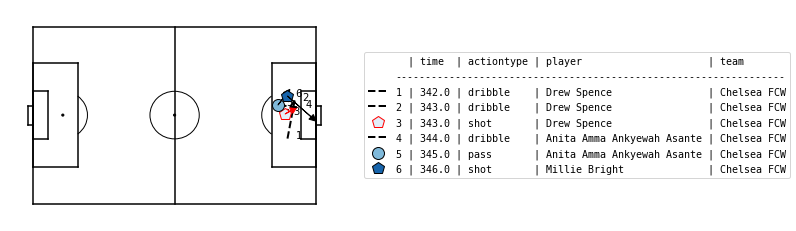

In [23]:
# Select relevant actions
df_actions_goal = df_actions.loc[138 - 5: 138]
# Replace result, actiontype and bodypart IDs by their corresponding name
df_actions_goal = spadl.add_names(df_actions_goal)
# Add team and player names
df_actions_goal = df_actions_goal.merge(df_teams).merge(df_players)
# Create the plot
mps.actions(
    location=df_actions_goal[["start_x", "start_y", "end_x", "end_y"]],
    action_type=df_actions_goal.type_name,
    team=df_actions_goal.team_name,
    result=df_actions_goal.result_name == "success",
    label=df_actions_goal[["time_seconds", "type_name", "player_name", "team_name"]],
    labeltitle=["time", "actiontype", "player", "team"],
    zoom=False
)

### Step 4 - Computing xT

- We will now compute the first of the key metrics we will use in our analysis xT
- For each successful action (an action the moves the ball and retains posession - it will filter out all other actions) - it will assign a value, meant to represent how valuable each area of the pitch is, based on a sequence of actions leading up to a shot

In [24]:
# 1. Load a set of actions to train the model on
actions = df_actions

# 2. Train xT model
xTModel = xthreat.ExpectedThreat(l=16, w=12)
xTModel.fit(actions)

# 3. Rate ball-progressing actions
# xT should only be used to value actions that move the ball
# and that keep the current team in possession of the ball
mov_actions = xthreat.get_successful_move_actions(actions)
mov_actions["xT_value"] = xTModel.predict(mov_actions)

# iterations:  45


- We can now plot the value of each zone on the pitch to see what were the most valuable areas of this pitch for this match. 

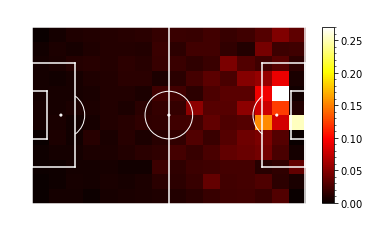

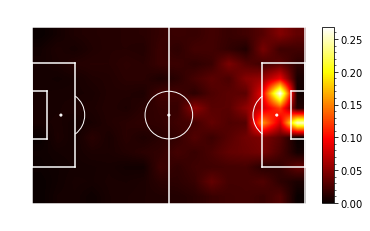

<AxesSubplot:>

In [28]:
# Inspect the learned heatmap
mps.heatmap(xTModel.xT, cmap="hot", linecolor="white", cbar="True")

# Inspect the interpolated heatmap used for predictions
interp = xTModel.interpolator()
x = np.linspace(0, 105, 1050)
y = np.linspace(0, 68, 680)
mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")

- Or we can visualise the actions acording to the xT of the area they happened in

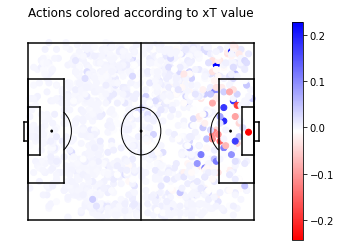

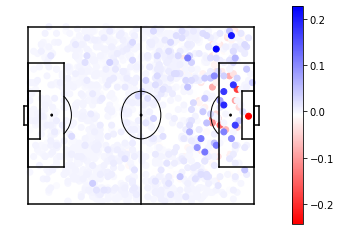

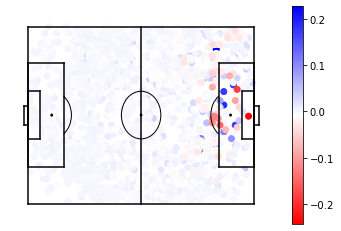

In [29]:
## Visualize xT predictions 
a = mov_actions

# Show scatterplot of actions colored according to xT value
mps.field(show=False)
plt.title("Actions colored according to xT value")
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

# Show actions with low xT Values on top
a = a.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

# Show actions with high xT Values on top
a = a.sort_values("xT_value", ascending=False)
mps.field(show=False)
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

### Step 5 - Compute VAEP

Similarly to computing xT, we will follow a few steps as explined in the documentation. 

First we need to fit the model, which requires 2 inputs, features and labels. Those are computed through their respective methods below. 

Once we have a fitted model, we rate the actions to get back the offensive, defensive and overall VAEP score. 

This is a measure specific to the action itself, rather than the location of the action as in the previous metric. 

In [65]:
# Fit Model
# setting this to 5 as our analysis will focus on 5 previous actions

VAEP_model = VAEP(nb_prev_actions=5)

# load the game's events
game_events = SBL.events(game_id)

# convert the events to actions
home_team_id = df_games.at[game_id, "home_team_id"]
game_actions = spadl.statsbomb.convert_to_actions(game_events, home_team_id)
game_actions = socceraction.spadl.add_names(game_actions)

# compute features and labels
features = VAEP_model.compute_features(df_games.loc[game_id], game_actions)
labels = VAEP_model.compute_labels(df_games.loc[game_id], game_actions)

# fit the model
VAEP_model.fit(features, labels)

[0]	validation_0-auc:0.64982
[1]	validation_0-auc:0.75315
[2]	validation_0-auc:0.74984
[3]	validation_0-auc:0.75208
[4]	validation_0-auc:0.89102
[5]	validation_0-auc:0.89625
[6]	validation_0-auc:0.88974
[7]	validation_0-auc:0.89667
[8]	validation_0-auc:0.89465
[9]	validation_0-auc:0.89529
[10]	validation_0-auc:0.88729
[11]	validation_0-auc:0.93474
[12]	validation_0-auc:0.93154
[13]	validation_0-auc:0.92877
[14]	validation_0-auc:0.92045
[15]	validation_0-auc:0.93666
[16]	validation_0-auc:0.93826
[17]	validation_0-auc:0.93997
[18]	validation_0-auc:0.93911
[19]	validation_0-auc:0.94252
[20]	validation_0-auc:0.94039
[21]	validation_0-auc:0.94317
[22]	validation_0-auc:0.94210
[23]	validation_0-auc:0.93655
[24]	validation_0-auc:0.93165
[25]	validation_0-auc:0.93709
[26]	validation_0-auc:0.95138
[27]	validation_0-auc:0.94562
[28]	validation_0-auc:0.95991
[29]	validation_0-auc:0.95564
[30]	validation_0-auc:0.95991
[31]	validation_0-auc:0.96545
[32]	validation_0-auc:0.96183
[33]	validation_0-au

In [61]:
# Rate actions

df_events = SBL.events(game_id)
home_team_id = df_games.at[game_id, "home_team_id"]
df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id)
ratings = VAEP_model.rate(df_games.loc[game_id], df_actions)

In [63]:
df_actions = pd.concat([df_actions, ratings], axis=1)

In [64]:
df_actions.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,offensive_value,defensive_value,vaep_value
0,7298,2a456ec2-352c-499b-b5cc-e68bf84c7e9a,1,0.0,971,4647.0,52.058824,33.569620,50.294118,30.987342,0,1,0,0,0.000000,-0.0,0.000000
1,7298,7e908bd8-8e2f-44f8-9cc6-0435cd9ed3ed,1,0.0,971,4659.0,50.294118,30.987342,45.000000,27.544304,21,1,0,1,-0.005867,-0.0,-0.005867
2,7298,38023613-6b26-44e2-a0f8-9aab9960d2ff,1,0.0,971,4659.0,45.000000,27.544304,31.764706,3.443038,0,1,0,2,0.003603,-0.0,0.003603
3,7298,0d016edd-87cf-4e77-80fa-4504f367db00,1,2.0,971,5088.0,31.764706,3.443038,10.588235,7.746835,21,1,0,3,0.006997,-0.0,0.006997
4,7298,ccb57323-17d3-43db-8ae4-0d170c59c9cb,1,6.0,971,5088.0,10.588235,7.746835,10.588235,7.746835,19,0,0,4,0.046546,-0.0,0.046546


This metric is actually giving us both defensive and offensive value, along side the overall score. For our analysis we will focus on the overall VAEP Score. 